In [1]:
import torch
import torch.nn as nn
import numpy as np

In [2]:
class ReLUBasis(nn.Module):
    def __init__(self, input_size, output_size, num_basis_fns=20):
        super(ReLUBasis, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.num_basis_fns = num_basis_fns
        self.a = nn.Parameter(torch.randn(input_size, num_basis_fns))
        self.b = nn.Parameter(torch.randn(input_size, num_basis_fns))
        self.linear = nn.Linear(num_basis_fns, output_size)

    def forward(self, x):
        basis_functions = torch.relu(self.a * x.unsqueeze(2) - self.b)
        return self.linear(basis_functions.sum(dim=1))


class KanNoBspline(nn.Module):
    def __init__(self, input_size, hid_sizes, output_size, num_basis_funs=20):
        super(KanNoBspline, self).__init__()
        layers = []
        curr_size = input_size

        for hid_size in hid_sizes:
            layers.append(ReLUBasis(curr_size, hid_size, num_basis_funs))
            curr_size = hid_size

        layers.append(ReLUBasis(curr_size, output_size, num_basis_funs))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


relubasis = ReLUBasis(3, 5)
fast_kan = KanNoBspline(1, [10, 8], 1)

In [3]:
def generate_data(num_samples=100):
    x = np.linspace(0, 1, num_samples)
    y = np.sin(2 * np.pi * x) + np.random.normal(scale=0.1, size=x.shape)
    return x.reshape(-1, 1), y


x_train, y_train = generate_data(100)
x_train_tensor = torch.Tensor(x_train)
y_train_tensor = torch.Tensor(y_train).reshape(-1, 1)

In [4]:
model = KanNoBspline(1, [10, 8], 1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(x_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    loss.backward()
    optimizer.step()

    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

model.eval()
with torch.no_grad():
    predictions = model(x_train_tensor).numpy()

Epoch [50/500], Loss: 0.3316
Epoch [100/500], Loss: 0.1601
Epoch [150/500], Loss: 0.1372
Epoch [200/500], Loss: 0.1133
Epoch [250/500], Loss: 0.0897
Epoch [300/500], Loss: 0.0647
Epoch [350/500], Loss: 0.0351
Epoch [400/500], Loss: 0.0176
Epoch [450/500], Loss: 0.0130
Epoch [500/500], Loss: 0.0109


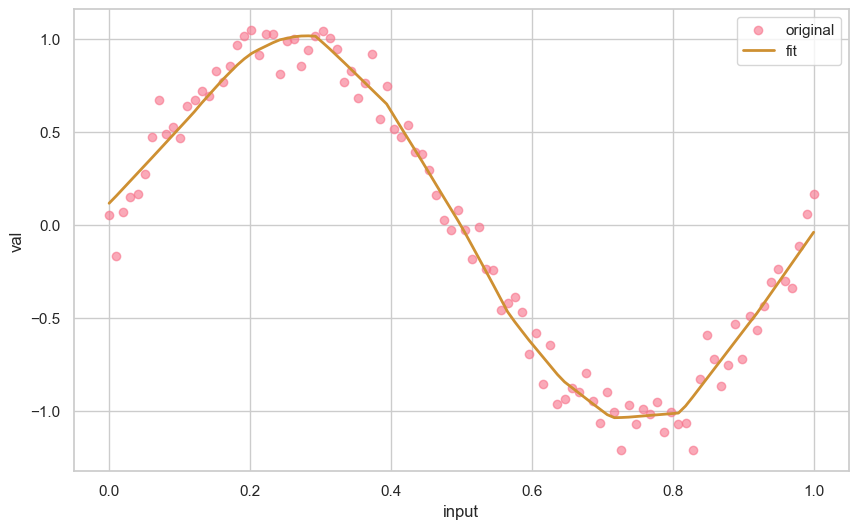

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
palette = sns.color_palette("husl", 8)

plt.figure(figsize=(10, 6))
plt.scatter(x_train, y_train, color=palette[0], label="original", alpha=0.6)
plt.plot(x_train, predictions, color=palette[1], label="fit", linewidth=2)
plt.xlabel("input")
plt.ylabel("val")
plt.legend()
plt.show()